
# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from datetime import date
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Analyze and Clean Input Data
## 1.1. Portfolio Dataset
**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

### 1.1.1. Analyze

In [3]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

In [4]:
portfolio.head(1000)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
print('Data has the following structure: {}\n'.format(type(portfolio)))
print(portfolio.dtypes)
print('\nDataframe has the {} rows and {} columns'.format(portfolio.shape[0], portfolio.shape[1]))

Data has the following structure: <class 'pandas.core.frame.DataFrame'>

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

Dataframe has the 10 rows and 6 columns


In [6]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

### 1.1.2. Clean

In [7]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

def clean_portfolio(df):
    
    '''
    input: dataframe portfolio
    return: cleaned dataframe portfolio

        1. Rename column "id" to "offer_id" and "reward" to "reward_offer"
        2. Create dummy columns for different communication channels
    '''
    
    df = df.rename(columns= {'id' : 'offer_id', 'reward' : 'reward_offer'})
    dummy_variables = pd.get_dummies(df['channels'].apply(pd.Series).stack()).groupby(level=0).sum()
    df = pd.concat([df, dummy_variables], axis=1).drop('channels', axis=1)
    
    return df 

In [8]:
portfolio = clean_portfolio(portfolio)

## 1.2. Profile Dataset
**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

### 1.2.1. Analyze

In [9]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)

In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
print('Data has the following structure: {}\n'.format(type(profile)))
print(profile.dtypes)
print('\nDataframe has the {} rows and {} columns'.format(profile.shape[0], profile.shape[1]))

Data has the following structure: <class 'pandas.core.frame.DataFrame'>

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

Dataframe has the 17000 rows and 5 columns


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'became_member_on'}>],
       [<Axes: title={'center': 'income'}>, <Axes: >]], dtype=object)

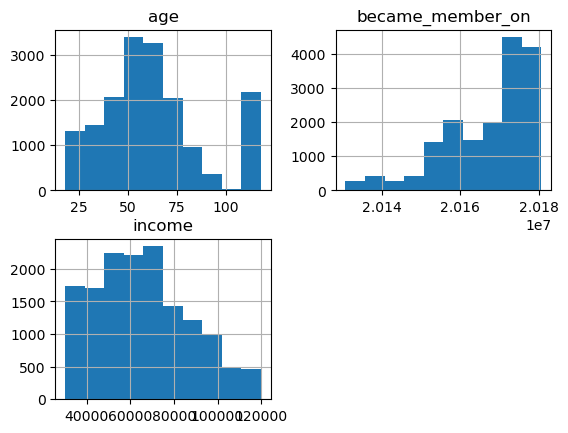

In [12]:
profile.hist()

Outliers in column "age".

In [13]:
print(round(profile.isnull().sum()/profile.shape[0]*100, 2))
print('\n')

gender              12.79
age                  0.00
id                   0.00
became_member_on     0.00
income              12.79
dtype: float64




In [14]:
ids_gender_income_missing = profile[(profile['gender'].isnull() == True) | (profile['income'].isnull() == True)]['id'].tolist()

<Axes: >

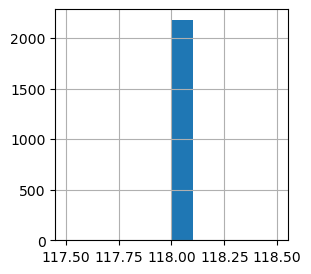

In [15]:
profile[profile['id'].isin(ids_gender_income_missing)]['age'].hist(figsize = (3,3))

All rows with missing values in income and/or gender have age = 118.

In [16]:
profile_outliers = profile[profile['id'].isin(ids_gender_income_missing)]
profile_outliers.describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


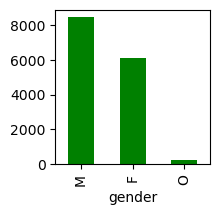

In [17]:
profile['gender'].value_counts().plot(kind = 'bar', figsize = (2,2), color = "green");

Gender = "O" expected to mean "other" and will be treated as own category for remainder of the analysis.

### 1.2.2. Clean

Decision to keep missing values in the dataset as the overall behaviour of customers without their demograpical information might be of interest as well to analyze effectiveness of different kinds of offer types. If demograpical information analyzed at later point, missing values will be removed.

In [18]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)

def clean_profile(df):
    
    '''
    input: dataframe profile
    return: cleaned dataframe profile

        1. Replace age = 118 with NaN
        2. rename column "id" to "member_id"
        3. change format from column "became_member_on" to date format
        4. create dummy variable for gender
        5. add column "member_since_months" in months
        6. add column "age_cluster"
        7. add column "income_cluster"
    '''
    
    df['age'] = df['age'].apply(lambda x: np.nan if x == 118 else x)
    df = df.rename(columns = {'id' : 'member_id'})
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    dummy_variables = pd.get_dummies(df['gender'].apply(pd.Series).stack()).groupby(level=0).sum()
    df = pd.concat([df, dummy_variables], axis=1)
    df['member_since_months'] = df['became_member_on'].apply(lambda x: relativedelta(date.today(), x).months + relativedelta(date.today(), x).years*12)
    df['age_cluster']  = pd.cut(df['age'], 
                                [0,20,30,40,50,60,70,80,90,118], 
                                labels=['1 to 20', '21 to 30', '31 to 40',
                                        '41 to 50', '51 to 60', '61 to 70',
                                        '71 to 80', '81 to 90', '91 to oldest'])
    df['income_cluster']  = pd.cut(df['income'], 
                                [0,25000,50000,75000,100000,125000,150000,175000,250000], 
                                labels=['1 to 25k', '25k to 50k', '50k to 75k',
                                        '75k to 100k', '100k to 125k', '125k to 150k',
                                        '150k to 175k', '175k to highest'])
    
    return df

In [19]:
profile = clean_profile(profile)

In [20]:
print('\nDataframe has the {} rows and {} columns'.format(profile.shape[0], profile.shape[1]))
print('\nThere are {} distinct customer IDs in the dataset'.format(profile['member_id'].nunique()))


Dataframe has the 17000 rows and 11 columns

There are 17000 distinct customer IDs in the dataset


## 1.3. Transcript Dataset
**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### 1.3.1. Analyze

In [21]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

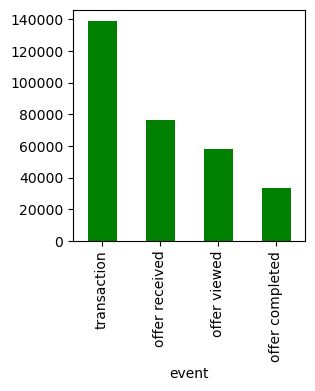

In [22]:
transcript['event'].value_counts()
transcript['event'].value_counts().plot.bar(figsize = (3,3), color = "green");

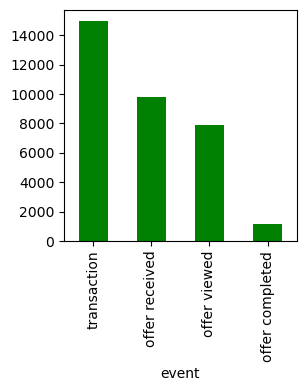

In [23]:
check_outlier_ids = transcript[transcript['person'].isin(ids_gender_income_missing)]
check_outlier_ids['event'].value_counts().plot.bar(figsize = (3,3), color = "green");

In [26]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [27]:
print('Data has the following structure: {}\n'.format(type(transcript)))
print(transcript.dtypes)
print('\nDataframe has the {} rows and {} columns'.format(transcript.shape[0], transcript.shape[1]))

Data has the following structure: <class 'pandas.core.frame.DataFrame'>

person    object
event     object
value     object
time       int64
dtype: object

Dataframe has the 306534 rows and 4 columns


In [28]:
print(round(transcript.isnull().sum()/profile.shape[0]*100, 2))
print('\n')

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64




In [29]:
transcript['event'].value_counts()

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

In [30]:
print('{} different members appear in dataset'.format(transcript['person'].nunique()))
print('{} different members had transaction'.format(transcript[transcript['event']=='transaction']['person'].nunique()))
print('{} different members received offer'.format(transcript[transcript['event']=='offer received']['person'].nunique()))
print('{} different members viewed offer'.format(transcript[transcript['event']=='offer viewed']['person'].nunique()))
print('{} different members completed offer'.format(transcript[transcript['event']=='offer completed']['person'].nunique()))

17000 different members appear in dataset
16578 different members had transaction
16994 different members received offer
16834 different members viewed offer
12774 different members completed offer


In [31]:
transcript[transcript['event'] == "transaction"].head(2)

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0


In [32]:
transcript[transcript['event'] == "offer received"].head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [33]:
transcript[transcript['event'] == "offer viewed"].head(2)

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [34]:
transcript[transcript['event'] == "offer completed"].head(2)

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0


### 1.3.2. Clean

In [35]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
def clean_transcript(df):
    
    '''
    input: dataframe transcript
    return: cleaned dataframe transcript

        1. rename column "person" to "member_id"
        2. create separate columns for "value" column
    '''
    
    df.rename(columns={'person':'member_id'}, inplace = True)
    df = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis = 1)
    df['offer_id'].fillna(df['offer id'], inplace=True)
    df.drop(['value', 'offer id'], axis = 1, inplace = True)
    df.rename(columns={'person' : 'member_id'}, inplace = True)

    return df

In [36]:
transcript = clean_transcript(transcript)

# 2. Join Datasets and creation of further columns

In [37]:
# including offer_type "informational"
print('Dataframe shape before join: {}'. format(transcript.shape))
df_full = pd.merge(transcript, profile, on='member_id', how='inner')
print('Dataframe shape after first join: {}'. format(df_full.shape))
df_full = pd.merge(df_full, portfolio, on='offer_id', how='left')
print('Dataframe shape after second join: {}'. format(df_full.shape))

# add number of events per member
events_per_member = df_full.groupby('member_id')['event'].value_counts().unstack(level='event').add_prefix('count ')
df_full = pd.merge(df_full, events_per_member, on='member_id', how='left')

df_full['offer_per_transaction'] = df_full['count offer received'] / df_full['count transaction']
df_full['offer_conversion_rate'] = df_full['count offer completed'] / df_full['count offer received']

print('Dataframe shape after third join: {}'. format(df_full.shape))
print('No. of distinct members after join: {}'. format(df_full['member_id'].nunique()))
print('No. of distinct offers after join: {}'. format(df_full['offer_id'].nunique()))

Dataframe shape before join: (306534, 6)
Dataframe shape after first join: (306534, 16)
Dataframe shape after second join: (306534, 24)
Dataframe shape after third join: (306534, 30)
No. of distinct members after join: 17000
No. of distinct offers after join: 10


In [38]:
# excluding offer_type "informational"
print('Dataframe shape before join: {}'. format(transcript.shape))
df_wo_info = pd.merge(transcript, profile, on='member_id', how='inner')
print('Dataframe shape after first join: {}'. format(df_wo_info.shape))
df_wo_info = pd.merge(df_wo_info, portfolio, on='offer_id', how='left')
df_wo_info = df_wo_info[df_wo_info['offer_type']!='informational']
print('Dataframe shape after second join: {}'. format(df_wo_info.shape))

# add number of events per member
events_per_member_filtered = df_wo_info.groupby('member_id')['event'].value_counts().unstack(level='event').add_prefix('count ')
df_wo_info = pd.merge(df_wo_info, events_per_member_filtered, on='member_id', how='left')

df_wo_info['offer_per_transaction'] = df_wo_info['count offer received'] / df_wo_info['count transaction']
df_wo_info['offer_conversion_rate'] = df_wo_info['count offer completed'] / df_wo_info['count offer received']

print('Dataframe shape after third join: {}'. format(df_wo_info.shape))
print('No. of distinct members after join: {}'. format(df_wo_info['member_id'].nunique()))
print('No. of distinct offers after join: {}'. format(df_wo_info['offer_id'].nunique()))

Dataframe shape before join: (306534, 6)
Dataframe shape after first join: (306534, 16)
Dataframe shape after second join: (280468, 24)
Dataframe shape after third join: (280468, 30)
No. of distinct members after join: 16996
No. of distinct offers after join: 8


# 3. Descriptive Analyses

In [41]:
cmap1 = plt.get_cmap("Paired")
colors1 = cmap1(range(15))
cmap2 = plt.get_cmap("tab20b")
colors2 = cmap2(range(15))
cmap3 = plt.get_cmap("tab20")
colors3 = cmap3(range(15))

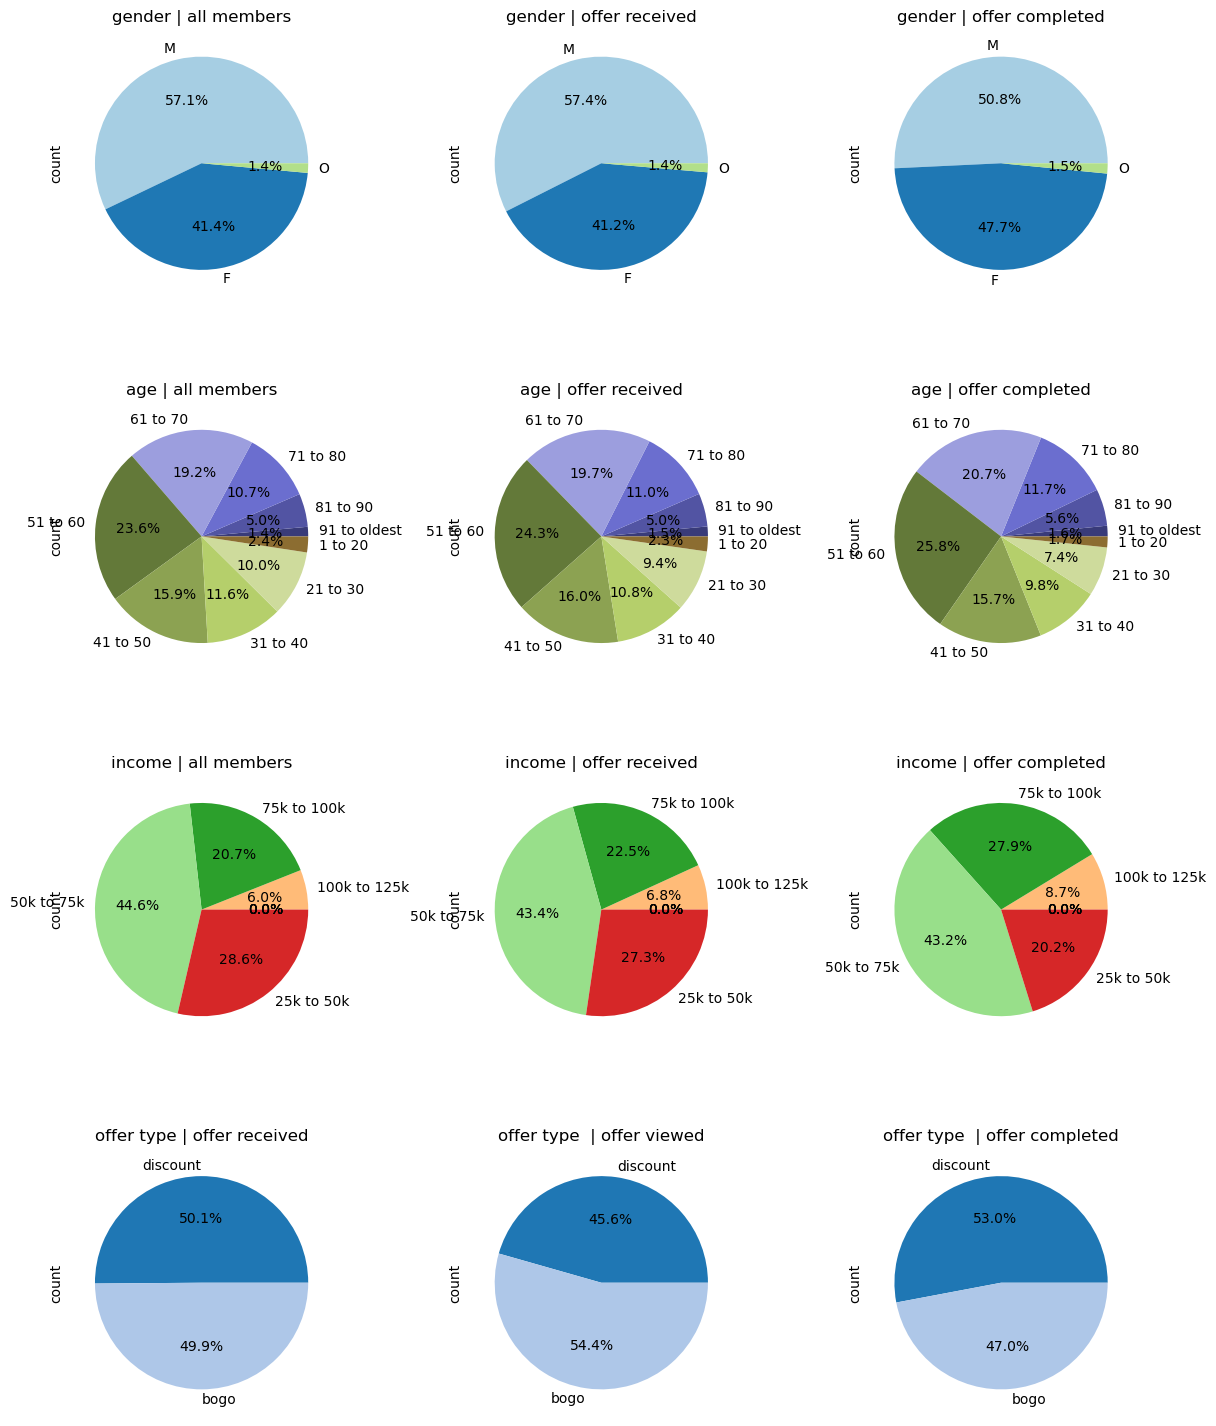

In [42]:
fi, ax = plt.subplots(4,3, figsize=(14,18))

#prepare data
members_all = df_wo_info.dropna(subset=['age','income','gender'])
members_rec = members_all[members_all['event']=='offer received']
members_view = members_all[members_all['event']=='offer viewed']
members_comp = members_all[members_all['event']=='offer completed']

ax1 = ax[0][0]
ax2 = ax[0][1]
ax3 = ax[0][2]
ax4 = ax[1][0]
ax5 = ax[1][1]
ax6 = ax[1][2]
ax7 = ax[2][0]
ax8 = ax[2][1]
ax9 = ax[2][2]
ax10 = ax[3][0]
ax11 = ax[3][1]
ax12 = ax[3][2]

ax1 = (members_all['gender'].value_counts() / members_all.shape[0]).plot.pie(ax= ax1, colors=colors1, autopct='%0.1f%%')
ax2 = (members_rec['gender'].value_counts() / members_rec.shape[0]).plot.pie(ax= ax2, colors=colors1, autopct='%0.1f%%')
ax3 = (members_comp['gender'].value_counts() / members_comp.shape[0]).plot.pie(ax= ax3, colors=colors1, autopct='%0.1f%%')

ax4 = (members_all['age_cluster'].value_counts().sort_index(ascending=False) / members_all.shape[0]).plot.pie(ax= ax4, colors=colors2, autopct='%0.1f%%')
ax5 = (members_rec['age_cluster'].value_counts().sort_index(ascending=False) / members_rec.shape[0]).plot.pie(ax= ax5, colors=colors2, autopct='%0.1f%%')
ax6 = (members_comp['age_cluster'].value_counts().sort_index(ascending=False) / members_comp.shape[0]).plot.pie(ax= ax6, colors=colors2, autopct='%0.1f%%')

ax7 = (members_all['income_cluster'].value_counts().sort_index(ascending=False) / members_all.shape[0]).plot.pie(ax= ax7, colors=colors3, autopct='%0.1f%%')
ax8 = (members_rec['income_cluster'].value_counts().sort_index(ascending=False) / members_rec.shape[0]).plot.pie(ax= ax8, colors=colors3, autopct='%0.1f%%')
ax9 = (members_comp['income_cluster'].value_counts().sort_index(ascending=False) / members_comp.shape[0]).plot.pie(ax= ax9, colors=colors3, autopct='%0.1f%%')

ax10 = (members_rec['offer_type'].value_counts().sort_index(ascending=False) / members_all.shape[0]).plot.pie(ax= ax10, colors=colors3, autopct='%0.1f%%')
ax11 = (members_view['offer_type'].value_counts().sort_index(ascending=False) / members_rec.shape[0]).plot.pie(ax= ax11, colors=colors3, autopct='%0.1f%%')
ax12 = (members_comp['offer_type'].value_counts().sort_index(ascending=False) / members_comp.shape[0]).plot.pie(ax= ax12, colors=colors3, autopct='%0.1f%%')

#titles
ax1.set_title('gender | all members')
ax2.set_title('gender | offer received')
ax3.set_title('gender | offer completed')
ax4.set_title('age | all members')
ax5.set_title('age | offer received')
ax6.set_title('age | offer completed')
ax7.set_title('income | all members')
ax8.set_title('income | offer received')
ax9.set_title('income | offer completed')
ax10.set_title('offer type | offer received')
ax11.set_title('offer type  | offer viewed')
ax12.set_title('offer type  | offer completed')

plt.subplots_adjust(wspace=0.4, hspace=0.4)

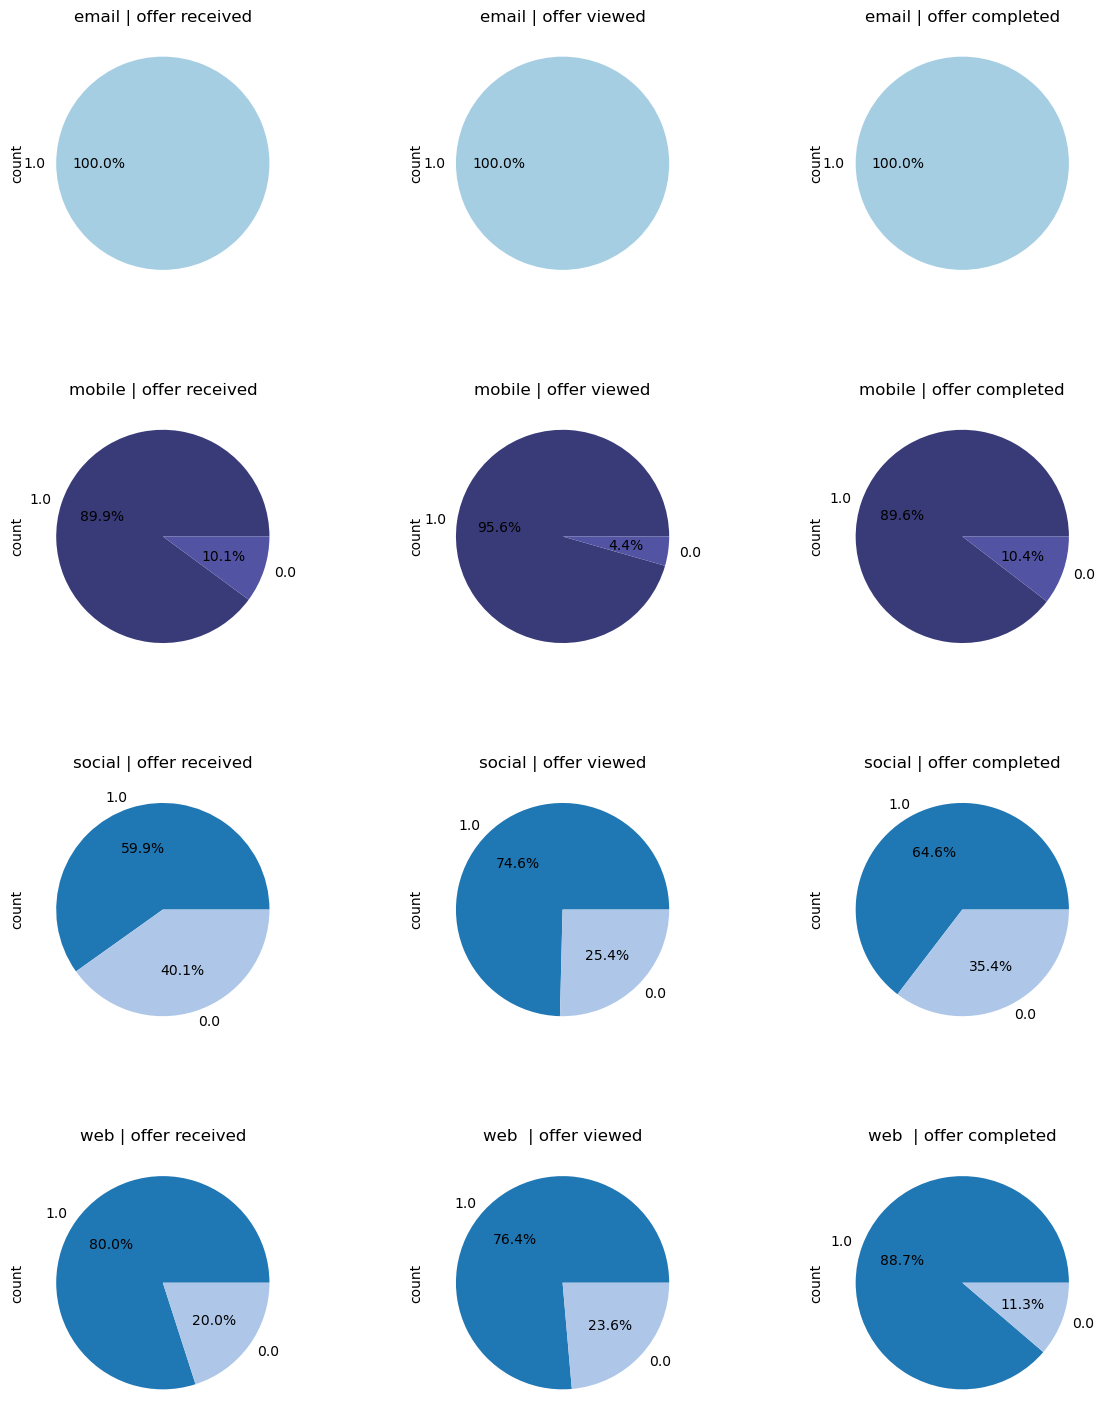

In [43]:
fi, ax = plt.subplots(4,3, figsize=(14,18))

#prepare data
members_all = df_full.dropna(subset=['age','income','gender'])
members_rec = members_all[members_all['event']=='offer received']
members_view = members_all[members_all['event']=='offer viewed']
members_comp = members_all[members_all['event']=='offer completed']

ax1 = ax[0][0]
ax2 = ax[0][1]
ax3 = ax[0][2]
ax4 = ax[1][0]
ax5 = ax[1][1]
ax6 = ax[1][2]
ax7 = ax[2][0]
ax8 = ax[2][1]
ax9 = ax[2][2]
ax10 = ax[3][0]
ax11 = ax[3][1]
ax12 = ax[3][2]

ax1 = (members_rec['email'].value_counts() / members_rec.shape[0]).plot.pie(ax= ax1, colors=colors1, autopct='%0.1f%%')
ax2 = (members_view['email'].value_counts() / members_view.shape[0]).plot.pie(ax= ax2, colors=colors1, autopct='%0.1f%%')
ax3 = (members_comp['email'].value_counts() / members_comp.shape[0]).plot.pie(ax= ax3, colors=colors1, autopct='%0.1f%%')

ax4 = (members_rec['mobile'].value_counts().sort_index(ascending=False) / members_rec.shape[0]).plot.pie(ax= ax4, colors=colors2, autopct='%0.1f%%')
ax5 = (members_view['mobile'].value_counts().sort_index(ascending=False) / members_view.shape[0]).plot.pie(ax= ax5, colors=colors2, autopct='%0.1f%%')
ax6 = (members_comp['mobile'].value_counts().sort_index(ascending=False) / members_comp.shape[0]).plot.pie(ax= ax6, colors=colors2, autopct='%0.1f%%')

ax7 = (members_rec['social'].value_counts().sort_index(ascending=False) / members_rec.shape[0]).plot.pie(ax= ax7, colors=colors3, autopct='%0.1f%%')
ax8 = (members_view['social'].value_counts().sort_index(ascending=False) / members_view.shape[0]).plot.pie(ax= ax8, colors=colors3, autopct='%0.1f%%')
ax9 = (members_comp['social'].value_counts().sort_index(ascending=False) / members_comp.shape[0]).plot.pie(ax= ax9, colors=colors3, autopct='%0.1f%%')

ax10 = (members_rec['web'].value_counts().sort_index(ascending=False) / members_rec.shape[0]).plot.pie(ax= ax10, colors=colors3, autopct='%0.1f%%')
ax11 = (members_view['web'].value_counts().sort_index(ascending=False) / members_view.shape[0]).plot.pie(ax= ax11, colors=colors3, autopct='%0.1f%%')
ax12 = (members_comp['web'].value_counts().sort_index(ascending=False) / members_comp.shape[0]).plot.pie(ax= ax12, colors=colors3, autopct='%0.1f%%')

#titles
ax1.set_title('email | offer received')
ax2.set_title('email | offer viewed')
ax3.set_title('email | offer completed')
ax4.set_title('mobile | offer received')
ax5.set_title('mobile | offer viewed')
ax6.set_title('mobile | offer completed')
ax7.set_title('social | offer received')
ax8.set_title('social | offer viewed')
ax9.set_title('social | offer completed')
ax10.set_title('web | offer received')
ax11.set_title('web  | offer viewed')
ax12.set_title('web  | offer completed')

plt.subplots_adjust(wspace=0.4, hspace=0.4)

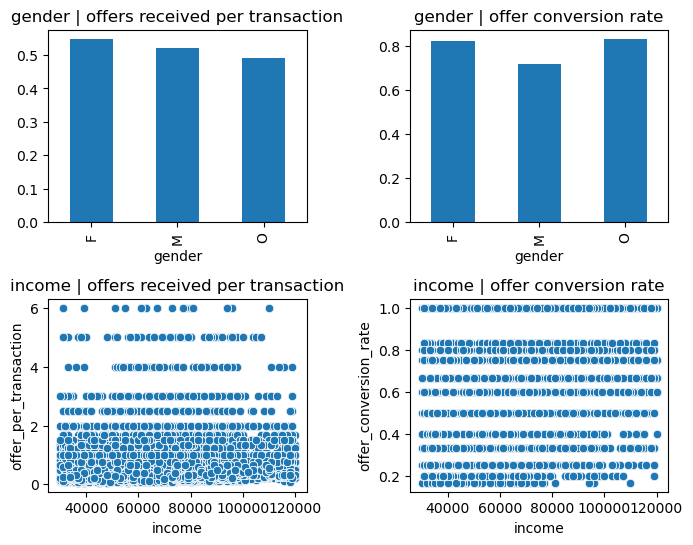

In [44]:
fi, ax = plt.subplots(2,2, figsize=(8,6))

ax1 = ax[0][0]
ax2 = ax[0][1]
ax3 = ax[1][0]
ax4 = ax[1][1]

member_stats = df_wo_info[['member_id','gender','income','member_since_months',
                           'time','count offer completed','count offer received',
                           'count offer viewed', 'count transaction',
                           'offer_per_transaction', 'offer_conversion_rate']].drop_duplicates()

ax1 = (member_stats.groupby('gender')['offer_per_transaction'].mean()).plot.bar(ax= ax1)
ax2 = (member_stats.groupby('gender')['offer_conversion_rate'].mean()).plot.bar(ax= ax2)

ax3 = sns.scatterplot(data=member_stats, x='income', y='offer_per_transaction', ax =ax3);
ax4 = sns.scatterplot(data=member_stats, x='income', y='offer_conversion_rate', ax =ax4);

#titles
ax1.set_title('gender | offers received per transaction')
ax2.set_title('gender | offer conversion rate')
ax3.set_title('income | offers received per transaction')
ax4.set_title('income | offer conversion rate')

plt.subplots_adjust(wspace=0.4, hspace=0.4)

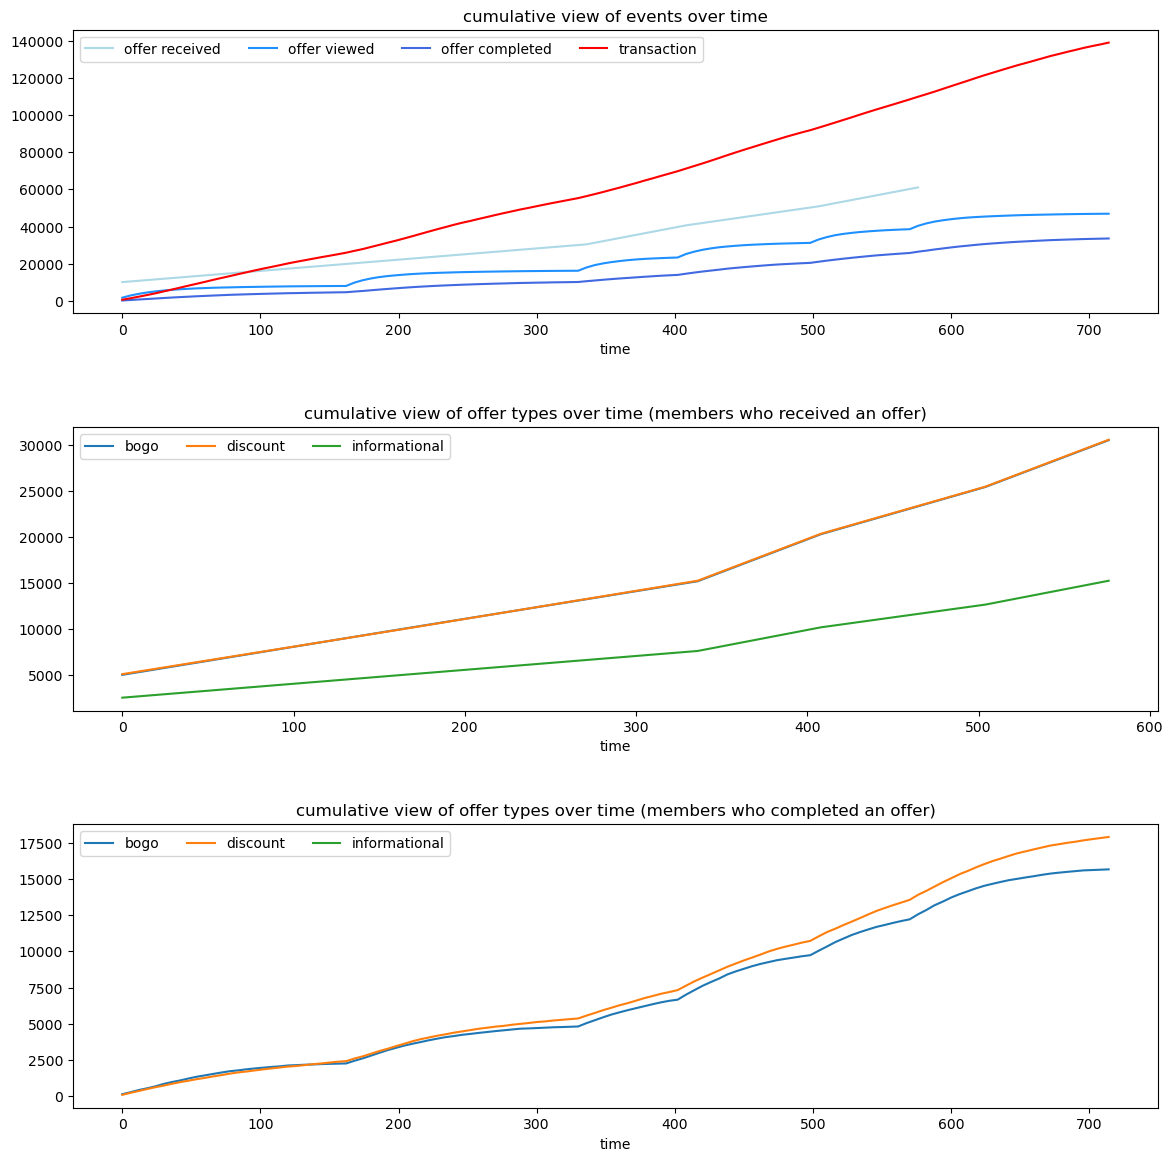

In [46]:
f, ax = plt.subplots(3,1, figsize=(14, 14))

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]

data_full = df_full
data_wo_info = df_wo_info

offers_received = data_wo_info[data_wo_info['event']=='offer received'].groupby('time')['event'].count().cumsum().rename('offer received').plot(ax=ax1, color =  'lightblue')
offers_viewed = data_wo_info[data_wo_info['event']=='offer viewed'].groupby('time')['event'].count().cumsum().rename('offer viewed').plot(ax=ax1, color = 'dodgerblue')
offers_completed = data_wo_info[data_wo_info['event']=='offer completed'].groupby('time')['event'].count().cumsum().rename('offer completed').plot(ax=ax1, color = 'royalblue')
transactions = data_wo_info[data_wo_info['event']=='transaction'].groupby('time')['event'].count().cumsum().rename('transaction').plot(ax=ax1, color = 'red')

bogo1 = data_full[(data_full['offer_type']=='bogo')&(data_full['event']=='offer received')].groupby('time')['event'].count().cumsum().rename('bogo').plot(ax=ax2)
discount1 = data_full[(data_full['offer_type']=='discount')&(data_full['event']=='offer received')].groupby('time')['event'].count().cumsum().rename('discount').plot(ax=ax2)
informational1 = data_full[(data_full['offer_type']=='informational')&(data_full['event']=='offer received')].groupby('time')['event'].count().cumsum().rename('informational').plot(ax=ax2)

bogo2 = data_full[(data_full['offer_type']=='bogo')&(data_full['event']=='offer completed')].groupby('time')['event'].count().cumsum().rename('bogo').plot(ax=ax3)
discount2 = data_full[(data_full['offer_type']=='discount')&(data_full['event']=='offer completed')].groupby('time')['event'].count().cumsum().rename('discount').plot(ax=ax3)
informational2 = data_full[(data_full['offer_type']=='informational')&(data_full['event']=='offer completed')].groupby('time')['event'].count().cumsum().rename('informational').plot(ax=ax3)

ax1.set_title('cumulative view of events over time')
ax1.legend(ncol=4, loc="upper left", frameon=True);

ax2.set_title('cumulative view of offer types over time (members who received an offer)')
ax2.legend(ncol=3, loc="upper left", frameon=True);

ax3.set_title('cumulative view of offer types over time (members who completed an offer)')
ax3.legend(ncol=3, loc="upper left", frameon=True);

plt.subplots_adjust(wspace=0.4, hspace=0.4)

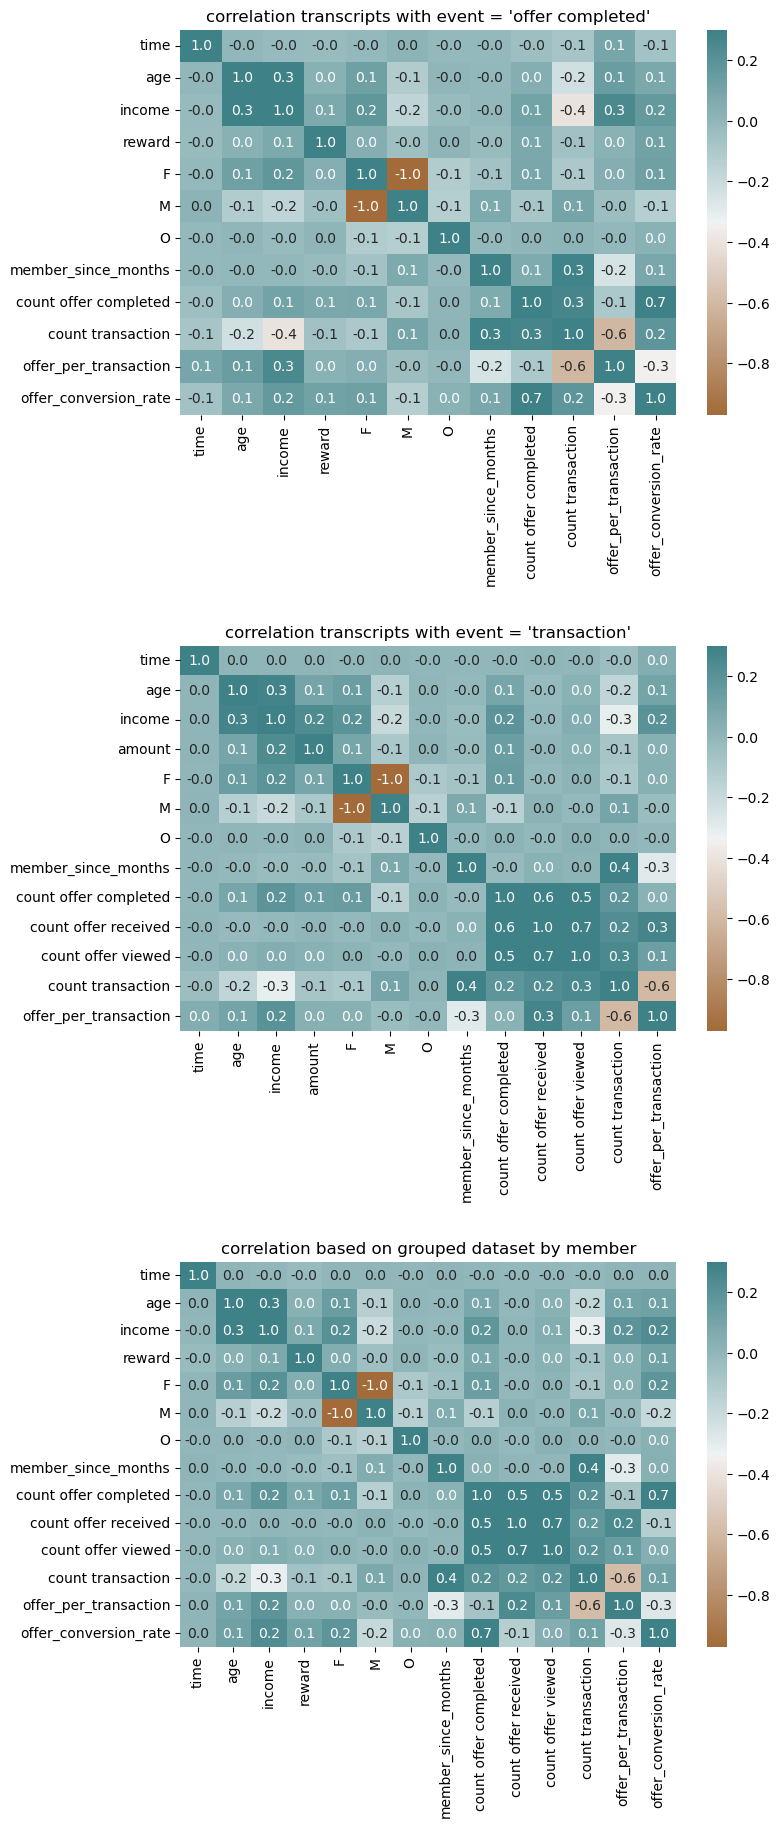

In [47]:
palette = sns.diverging_palette(40, 200, n=256)

f, ax = plt.subplots(3,1, figsize=(8, 21))

subset_offer_compl = df_wo_info[df_wo_info['event']=='offer completed'][['time', 'age', 'income', 'reward', 'F', 'M', 'O',
       'member_since_months', 'count offer completed', 'count transaction', 'offer_per_transaction', 'offer_conversion_rate']]
subset_transaction = df_wo_info[df_wo_info['event']=='transaction'][['time', 'age', 'income', 'amount', 'F', 'M', 'O',
       'member_since_months', 'count offer completed', 'count offer received', 'count offer viewed', 'count transaction', 'offer_per_transaction']]
subset_members = df_wo_info[['time', 'age', 'income', 'reward', 'F', 'M', 'O', 'member_since_months',
                     'count offer completed','count offer received', 'count offer viewed', 'count transaction', 'offer_per_transaction', 'offer_conversion_rate']].drop_duplicates()

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]

corr = subset_offer_compl.corr()
sns.heatmap(corr, vmax=.3, ax=ax1, cmap=palette, annot=True, fmt=".1f");

corr = subset_transaction.corr()
sns.heatmap(corr, vmax=.3, ax=ax2, cmap=palette, annot=True, fmt=".1f");

corr = subset_members.corr()
sns.heatmap(corr, vmax=.3, ax=ax3, cmap=palette, annot=True, fmt=".1f");

ax1.set_title("correlation transcripts with event = 'offer completed'");
ax2.set_title("correlation transcripts with event = 'transaction'");
ax3.set_title("correlation based on grouped dataset by member");

plt.subplots_adjust(wspace=0.4, hspace=0.6)

# 4. Model Estimation with Linear Regression

In [48]:
df_reg = df_wo_info[['F', 'M', 'O',
             'member_since_months', 'age', 'income',
             'count offer completed', 'count offer received',
             'count offer viewed', 'count transaction', 'offer_conversion_rate']].drop_duplicates()

df_reg.dropna(subset=['F','M','O','age','income'], inplace=True)
df_reg[['count offer completed', 'count offer received', 
              'count offer viewed', 'count transaction', 
              'offer_conversion_rate']] = df_reg[['count offer completed', 'count offer received', 
                                                        'count offer viewed', 'count transaction', 
                                                        'offer_conversion_rate']].fillna(0)
df_reg.reset_index(drop=True, inplace=True)

In [49]:
X = df_reg.drop(['count offer completed','count offer received','count offer viewed','offer_conversion_rate'], axis=1)
y = df_reg["offer_conversion_rate"]
features = list(X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

# Create an instance of the LinearRegression model
linreg = LinearRegression()

# Fit the model
linreg.fit(X_train, y_train)

# Predict target variable
y_pred = linreg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE) is:", round(mse,3))
print("Coefficient of Determination (R-squared) is:", round(r2,3))

coefficients = pd.DataFrame(list(zip(features, linreg.coef_)), columns=('Feature', 'Coefficient'))

Mean Squared Error (MSE) is: 0.095
Coefficient of Determination (R-squared) is: 0.344


In [50]:
coefficients

,Feature,Coefficient
0,F,0.022281
1,M,-0.092299
2,O,0.070017
3,member_since_months,0.001351
4,age,0.001666
5,income,0.000006
6,count transaction,0.035155
